In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
n = 10
y = np.arange(1, n+1) / n
y

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

## Setup

In [3]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
hydrophobicity = {'G': 0, 'A': 41, 'L':97, 'M': 74, 'F':100, 'W':97, 'K':-23, 'Q':-10, 'E':-31, 'S':-5, 'P':-46, 'V':76, 'I':99, 'C':49, 'Y':63, 'H':8, 'R':-14, 'N':-28, 'D':-55, 'T':13}
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset & Sampling

In [4]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    ds = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        for peptide in peptides:
            ds.append((aptamer, peptide))
    ds = list(set(ds)) #removed duplicates
    return ds

# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S'(train/test) contains S_train/S_test with double the size of S_train/S_test
def get_S_prime(kind="train"):
    if kind == "train":
        dset = S_train
    else:
        dset = S_test
    k = len(dset)
    S_prime_dict = dict.fromkeys(dset, 0) #indicator 0 means in S
    for _ in range(k):
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in S
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()] 
    np.random.shuffle(S_prime)
    return S_prime

# S new contains unseen new examples
def get_S_new(k):
    S_new = []
    for i in range(k):
        pair = (get_x(), get_y())
        S_new.append(pair)
    np.random.shuffle(S_new)
    return S_new
    
# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf    

In [5]:
aptamer_dataset_file = "../data/aptamer_dataset.json"
S = construct_dataset()
n = len(S)
m = int(0.8*n) #length of S_train
S_train = S[:m]
S_test = S[m:]
S_prime_train = get_S_prime("train") #use for sgd 
S_prime_test = get_S_prime("test") #use for sgd 
S_new = get_S_new(10*n) #use for eval
train_ds = np.hstack((S_train, S_prime_train[:len(S_prime_train)//2]))

## NN Model

In [6]:
class ConvNetSimple(nn.Module):
    def __init__(self):
        super(ConvNetSimple, self).__init__()
        self.cnn_apt_1 = nn.Conv1d(40, 100, 3) 
        self.cnn_apt_2 = nn.Conv1d(100, 50, 1)
        
        self.cnn_pep_1 = nn.Conv1d(8, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 25, 1)

        
        self.relu = nn.ReLU()
        self.name = "ConvNetSimple"
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, self.cnn_apt_2, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu, self.cnn_pep_2, self.relu)
        
        self.fc1 = nn.Linear(275, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [7]:
class LinearConv1d(nn.Module):
    def __init__(self):
        super(LinearConv1d, self).__init__()
        x
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [8]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.lin_apt_1 = nn.Linear(160, 100) 
        self.lin_apt_2 = nn.Linear(100, 50)
        self.lin_apt_3 = nn.Linear(50, 10)
        
        self.lin_pep_1 = nn.Linear(160, 50)
        self.lin_pep_2 = nn.Linear(50, 10)

        self.relu = nn.ReLU()
        
        self.name = "LinearNet"
        
        self.lin_apt = nn.Sequential(self.lin_apt_1, self.lin_apt_2, self.lin_apt_3)
        self.lin_pep = nn.Sequential(self.lin_pep_1, self.lin_pep_2)
        
        self.fc1 = nn.Linear(20, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        apt = self.lin_apt(apt)
        pep = self.lin_pep(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [9]:
class ConvNetComplex(nn.Module):
    def __init__(self):
        super(ConvNetComplex, self).__init__()
        self.name = "ConvNetComplex"
        
        self.cnn_apt_1 = nn.Conv1d(4, 1000, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(1000, 1000, 3, padding=2)
        self.cnn_apt_3 = nn.Conv1d(1000, 1000, 3, padding=2)
        self.cnn_apt_4 = nn.Conv1d(1000, 1000, 3, padding=2)
        self.cnn_apt_5 = nn.Conv1d(1000, 1000, 3, padding=2)
        self.cnn_apt_6 = nn.Conv1d(1000, 1000, 3, padding=2)
        
        self.cnn_pep_1 = nn.Conv1d(20, 500, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(500, 500, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(500, 500, 3, padding=2)
        self.cnn_pep_4 = nn.Conv1d(500, 500, 3, padding=2)
        self.cnn_pep_5 = nn.Conv1d(500, 500, 3, padding=2)
        self.cnn_pep_6 = nn.Conv1d(500, 500, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(3000, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_5(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_6(apt)))

        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)
        
        pep = self.pool1(self.relu(self.cnn_pep_1(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_3(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_4(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_5(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_6(pep)))
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [13]:
class VariedChannelsNet(nn.Module):
    def __init__(self):
        super(VariedChannelsNet, self).__init__()
        self.name = "VariedChannelsNet"
        
        self.cnn_apt_1 = nn.Conv1d(4, 1000, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(1000, 800, 3, padding=2)
        self.cnn_apt_3 = nn.Conv1d(800, 600, 3, padding=2)
        self.cnn_apt_4 = nn.Conv1d(600, 400, 3, padding=2)
        self.cnn_apt_5 = nn.Conv1d(400, 200, 3, padding=2)
        self.cnn_apt_6 = nn.Conv1d(200, 100, 3, padding=2)
        
        self.cnn_pep_1 = nn.Conv1d(20, 500, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(500, 450, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(450, 400, 3, padding=2)
        self.cnn_pep_4 = nn.Conv1d(400, 350, 3, padding=2)
        self.cnn_pep_5 = nn.Conv1d(350, 250, 3, padding=2)
        self.cnn_pep_6 = nn.Conv1d(250, 200, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        # conv --> relu --> pool after every one
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_5(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_6(apt)))

        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)
        
        pep = self.pool1(self.relu(self.cnn_pep_1(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_3(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_4(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_5(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_6(pep)))
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [21]:
class MinimizedVCNet(nn.Module):
    def __init__(self):
        super(MinimizedVCNet, self).__init__()
        self.name = "MinimizedVCNet"
        
        self.cnn_apt_1 = nn.Conv1d(4, 1000, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(1000, 500, 3, padding=2)
        self.cnn_apt_3 = nn.Conv1d(500, 100, 3, padding=2)
        
        self.cnn_pep_1 = nn.Conv1d(20, 500, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(500, 250, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(250, 100, 3, padding=2)

        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(800, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        # conv --> relu --> pool after every one
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))

        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)
        
        pep = self.pool1(self.relu(self.cnn_pep_1(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_3(pep)))
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [15]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [16]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (-1, apt.shape[0], apt.shape[1]))).to(device) #(1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (-1, pep.shape[0], pep.shape[1]))).to(device) #(1, 8, 20)
    return apt, pep

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y):
    x.requires_grad=True
    y.requires_grad=True
    x = x.to(device)
    y = y.to(device)
    out = model(x, y)
    return out

# Generates the samples used to calculate loss
def loss_samples(k, ds='train'): # S_train/S_test
    if ds == 'train':
        dset = S_train
    else:
        dset = S_test
    pairs = []
    for (apt, pep) in dset[:k]:
        x, y = convert(apt, pep)
        pairs.append((x, y))
    return pairs

# Generates the samples used to calculate loss from S_prime_train/S_prime_test
def prime_loss_samples(k, ds='train'): # S_prime_train/S_prime_test
    if ds == "train":
        dset = S_prime_train[len(S_prime_train)//2:]    
    else:
        dset = S_prime_test[len(S_prime_test)//2:]
    pairs = []
    for (apt, pep), ind in dset[:k]:
        pmf = get_y_pmf(pep)
        x, y = convert(apt, pep)
        pairs.append((x, y, ind, pmf))
    return pairs

# First term of the loss
def get_log_out(dataset='train'):
    outs = []
    if dataset == 'train':
        dset = train_loss_samples
    else:
        dset = test_loss_samples
    for (apt, pep) in dset:
        out = update(apt, pep)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

# Second term of loss
def get_out_prime(ds="train"):
    outs = []
    if ds == "train":
        dset = prime_train_loss_samples
        leng = m
    else:
        dset = prime_test_loss_samples
        leng = n-m
    for (apt, pep, ind, pmf) in dset:
        x = apt.to(device)
        y = pep.to(device)
        out = model(x, y)
        if ind == 0:
            factor = (2*leng*get_x_pmf()*pmf)/(1+leng*get_x_pmf()*pmf)
        else:
            factor = 2
        out_is = out.cpu().detach().numpy().flatten()[0] * factor
        outs.append(out_is)
    return np.average(outs)

## Plotting functions

def plot_loss(train_loss, test_loss, i, j, lamb, gamma):
    plt.plot(train_loss, 'b', label='Train loss')
    plt.plot(test_loss, 'y', label='Test loss')
    plt.ylabel("Loss")
    plt.xlabel("Number of iterations")
    plt.title('Loss after ' +  str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def plot_recall(train_recall, test_recall, i, j, lamb, gamma):
    plt.plot(train_recall, 'b', label='Train recall')
    plt.plot(test_recall, 'y', label='Test recall')
    plt.ylabel("Recall (%)")
    plt.xlabel("Number of iterations")
    plt.title('Recall after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def plot_ecdf_test(test_score, i, j, lamb, gamma):
    test_idx = np.argsort(test_score)
    test_id = test_idx >= 10000
    test = np.sort(test_score)
    test_c = ""
    for m in test_id:
        if m:
            test_c += 'y'
        else:
            test_c += 'g'
    n = test_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, test, c=test_c, label='Test CDF')
    plt.xlabel('CDF')
    plt.ylabel('Most recent 10,000 samples')
    plt.title('CDF after ' + str(i) + ' iterations, ' + str(j) + ' epochs, ' + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def plot_ecdf_train(train_score, i, j, lamb, gamma):
    #train_score consisits of [10000 scores generated] + [1000 scores from training set]
    train_idx = np.argsort(train_score)
    train_id = train_idx >= 10000
    train = np.sort(train_score)
    train_c = "" #colors
    for l in train_id:
        if l:
            train_c += "r"
        else:
            train_c += "b"
    n = train_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, train, c=train_c, label='Train CDF')
    plt.xlabel("CDF")
    plt.ylabel("Most recent 10,000 samples")
    plt.title('CDF after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def histogram(eval_scores, train_scores, test_scores):
    fig, ax = plt.subplots()
    plt.xlim(0, 1.1)
    sns.distplot(eval_scores , color="skyblue", label='New: not in dataset', ax=ax)
    sns.distplot(train_scores , color="gold", label='Train: in dataset', ax=ax)
    sns.distplot(test_scores, color='red', label='Test: in the dataset', ax=ax)
    ax.set_title("Distribution of Scores")
    ax.figure.set_size_inches(7, 4)
    ax.legend()
    plt.show()

In [17]:
train_loss_samples = loss_samples(k, 'train')
test_loss_samples = loss_samples(k, 'test')
prime_train_loss_samples = prime_loss_samples(k, 'train')
prime_test_loss_samples = prime_loss_samples(k, 'test')

## SGD

In [18]:
'''
lamb = hyperparameter
gamma = step size
run_from_checkpoint = path to a checkpointed model
save_checkpoings = file name
'''
def sgd(epochs=[1, 2, 3], 
        lamb=[10, 10, 10], 
        gamma=[1e-3, 1e-4, 1e-5], 
        run_from_checkpoint=None, 
        save_checkpoints=None): 
    
    if run_from_checkpoint is not None:
        checkpointed_model = run_from_checkpoint
        checkpoint = torch.load(checkpointed_model)
        
        optim = SGD(model.parameters(), lr=gamma[0])

        model.load_state_dict(checkpoint['model_state_dict'])
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        reloaded_epoch = checkpoint['epoch']
        print("Reloading model: " + str(model.name) + " at epoch: " + str(reloaded_epoch))
        epoch = reloaded_epoch
    else:
        model.apply(weights_init)
    
    model.to(device)
    
    train_losses = []
    test_losses = []
    total_epochs = 0
    train_recalls = []
    test_recalls = []
    train_correct = 0
    test_correct = 0
    train_recall_outputs = [] 
    test_recall_outputs = []
    new_outputs = []
    
    for i in range(len(epochs)):
        g = gamma[i]
        l = lamb[i]
        eps = epochs[i]
        epoch = 0
        optim = SGD(model.parameters(), lr=g)
        while epoch < eps:
            print("Training Epoch: ", total_epochs)
            
            for i, (aptamer, peptide, (apt_prime, pep_prime), indicator) in enumerate(tqdm.tqdm(train_ds)):
                if i == 0:
                    continue
                model.train()
                optim.zero_grad() 
                x, y = convert(aptamer, peptide) #sample x,y from S_train
                out = update(x, y) #get S_train output/score
                log_out = torch.log(out) 

                train_score = out.cpu().detach().numpy().flatten()[0] 
                if train_score > 0.6:
                    train_correct += 1 
                train_recall_outputs.append(train_score) 

                optim.zero_grad() 
                y_pmf = get_y_pmf(pep_prime)
                x_prime, y_prime = convert(apt_prime, pep_prime) #sample x', y' from S_prime_train
                out_prime = update(x_prime, y_prime) #get score from S_prime_train
                if indicator == 0:
                    factor = (2*m*get_x_pmf()*y_pmf)/(1+m*get_x_pmf()*y_pmf)
                else:
                    factor = 2
                out_prime = out_prime*factor #adjust for IS
                #print("Obj first part: ", out_prime.cpu().detach().numpy().flatten()[0]*lamb*indicator)
                #print("Obj second part: ", log_out.cpu().detach().numpy().flatten()[0])
                # Retain graph retains the graph for further operations
                (l*indicator*out_prime - log_out).backward(retain_graph=True) 
                optim.step()

                with torch.no_grad():
                    model.eval()

                x_test, y_test = convert(S_test[i%(n-m)][0], S_test[i%(n-m)][1]) #sample x,y from test set
                test_score = model(x_test, y_test).cpu().detach().numpy().flatten()[0]
                test_recall_outputs.append(test_score) 
                if test_score > 0.6:
                    test_correct += 1 

                #generate 10 unseen examples from S_new as compared 1 example from S_train/S_test for cdfs
                for x, y in S_new[10*i:10*(i+1)]:
                    x_new, y_new = convert(x, y) #generate unseen x'' and y'' from S_new
                    new_score = model(x_new, y_new).cpu().detach().numpy().flatten()[0] #get unknown score
                    new_outputs.append(new_score)

                if i % 10000 == 0:
                    train_loss = l*get_out_prime("train") - get_log_out('train') #training loss
                    #print("Train loss first part: ", lamb*get_out_prime("train"))
                    #print("Train loss second part: ", get_log_out('train'))
                    test_loss = (m/(n-m))*l*get_out_prime("test") - get_log_out('test') #test loss
                    #print("Test loss first part: ", lamb*get_out_prime("test"))
                    #print("Test loss second part: ", get_log_out('test'))
                    train_losses.append(train_loss)
                    test_losses.append(test_loss)

                    train_recall = 100*train_correct/(total_epochs*m + i) #training recall
                    train_recalls.append(train_recall) 
                    test_recall = 100*test_correct/(total_epochs*m + i) #test recall
                    test_recalls.append(test_recall)
                    if i > 1000:
                        train_score = np.asarray(new_outputs[-10000:] + train_recall_outputs[-1000:]) 
                        test_score = np.asarray(new_outputs[-10000:] + test_recall_outputs[-1000:])
                    else:
                        train_score = np.asarray(new_outputs + train_recall_outputs) #combine train and unknown scores
                        test_score = np.asarray(new_outputs + test_recall_outputs) #combibne test and unknown scores


                if i % 100000 == 0:
                    plot_recall(train_recalls, test_recalls, i, total_epochs, l, g)
                    plot_loss(train_losses, test_losses, i, total_epochs, l, g)
                    plot_ecdf_train(train_score, i, total_epochs, l, g)
                    plot_ecdf_test(test_score, i, total_epochs, l, g)
                    histogram(new_outputs[-1000:], train_recall_outputs[-1000:], test_recall_outputs[-1000:])
                    print("New score: ", np.average(new_outputs[-500:]))
                    print("Train score: ", np.average(train_score[-500:]))
                    print("Test score: ", np.average(test_score[-500:]))
        
            # Save after every epoch
            total_epochs += 1
            epoch += 1
            if save_checkpoints is not None:
                print("Saving to: ", save_checkpoints)
                checkpoint_name = save_checkpoints
                torch.save({'epoch': epoch,'model_state_dict': model.state_dict(), 'optimizer_state_dict': optim.state_dict()}, checkpoint_name)

## Hyperparameter tuning

In [22]:
# Hyperparameter search
gamma = [1e-2, 1e-3]
lamb = [5, 10]
EPOCHS = [3, 2]

  0%|          | 2/473047 [00:00<10:31:58, 12.48it/s]

Training Epoch:  0


 21%|██        | 100000/473047 [3:58:51<9:48:31, 10.56it/s]  

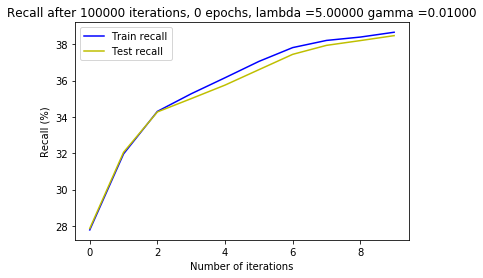

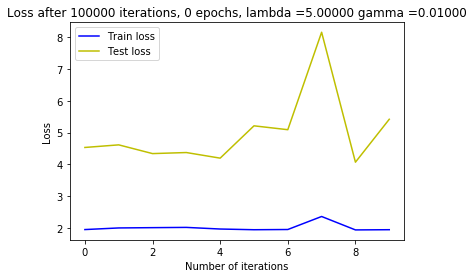

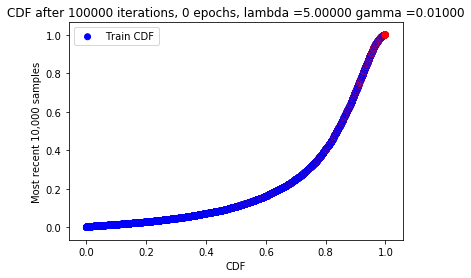

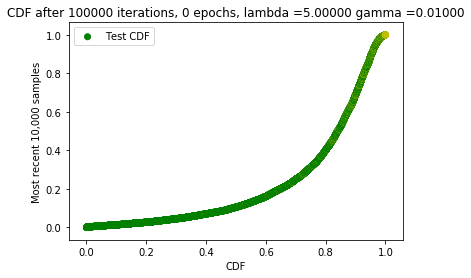

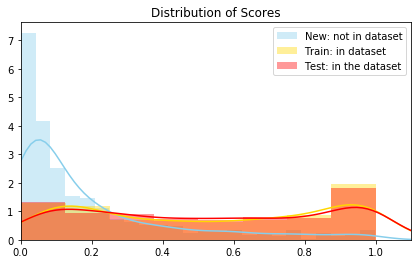

 21%|██        | 100002/473047 [4:00:58<3186:56:30, 30.75s/it]

New score:  0.19922464
Train score:  0.5225117
Test score:  0.5290912


 42%|████▏     | 199999/473047 [8:03:22<7:32:41, 10.05it/s]   

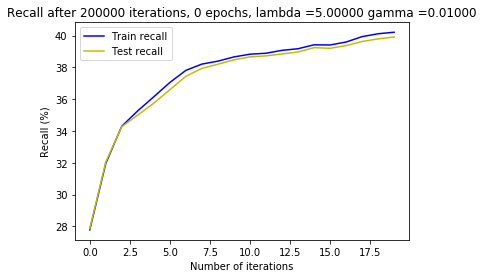

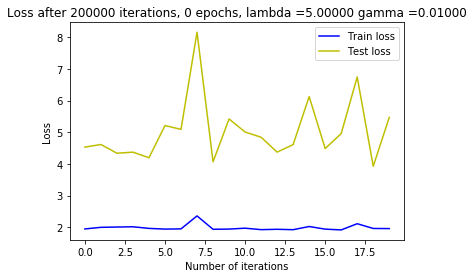

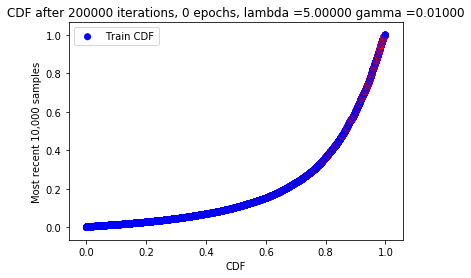

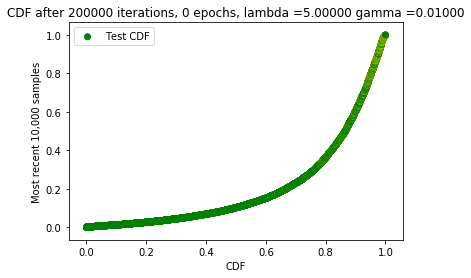

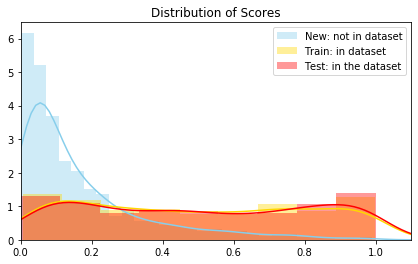

 42%|████▏     | 200002/473047 [8:05:25<1130:50:30, 14.91s/it]

New score:  0.1712538
Train score:  0.47469035
Test score:  0.482169


 63%|██████▎   | 300000/473047 [12:04:50<7:32:23,  6.38it/s]   

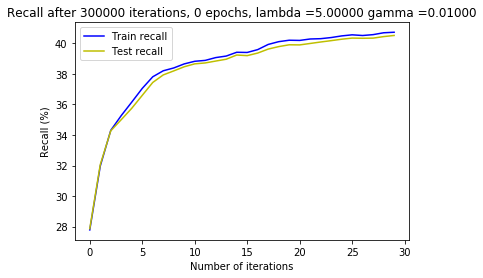

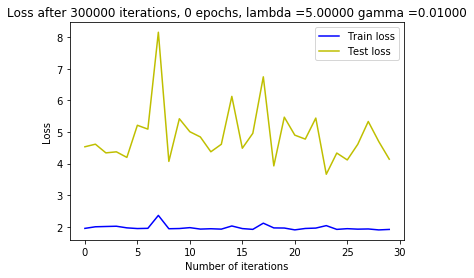

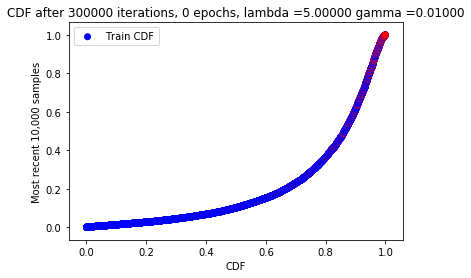

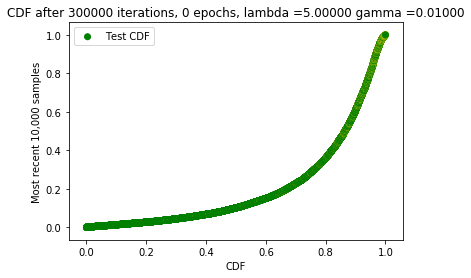

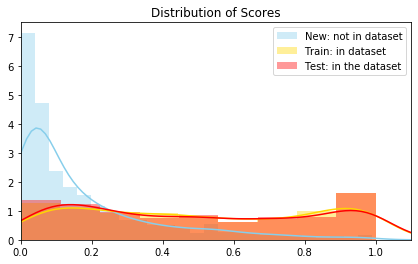

 63%|██████▎   | 300002/473047 [12:07:07<1388:05:01, 28.88s/it]

New score:  0.19775859
Train score:  0.49036792
Test score:  0.47020552


 85%|████████▍ | 399999/473047 [16:11:59<3:27:09,  5.88it/s]   

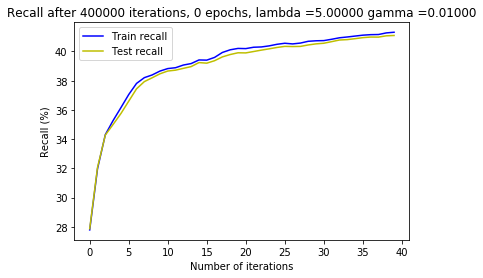

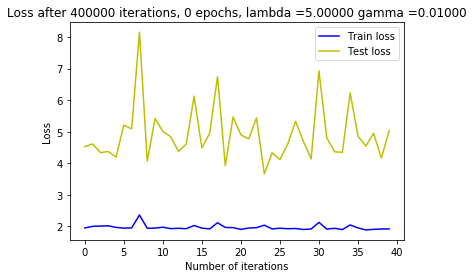

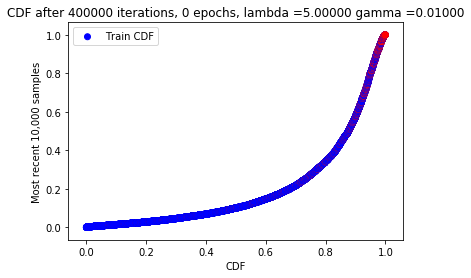

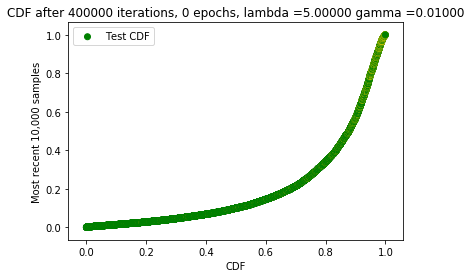

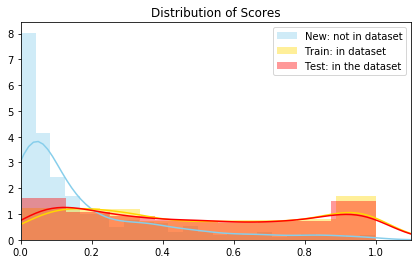

 85%|████████▍ | 400001/473047 [16:14:20<430:58:22, 21.24s/it]

New score:  0.18206167
Train score:  0.5192552
Test score:  0.48262665


100%|██████████| 473047/473047 [19:09:47<00:00,  6.86it/s]    


Saving to:  model_checkpoints/MinimizedVCNet/04242020.pth
Training Epoch:  1


 21%|██        | 100000/473047 [3:59:41<17:38:18,  5.87it/s] 

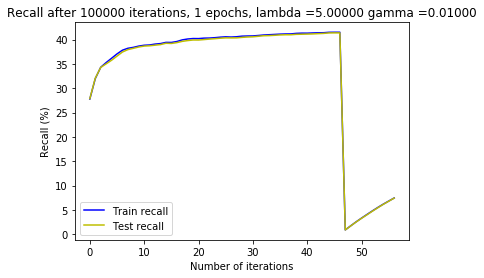

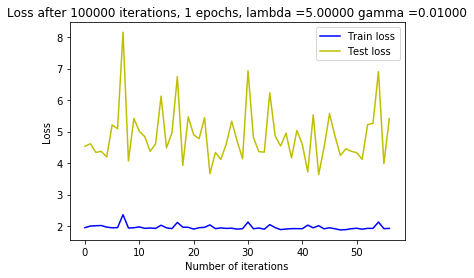

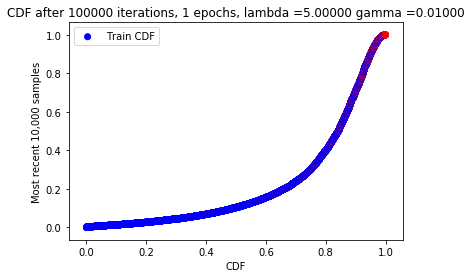

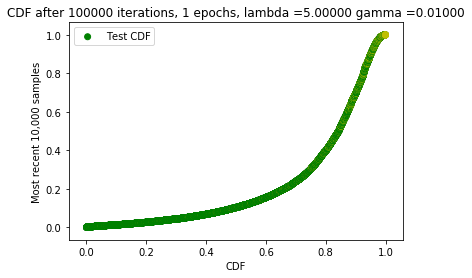

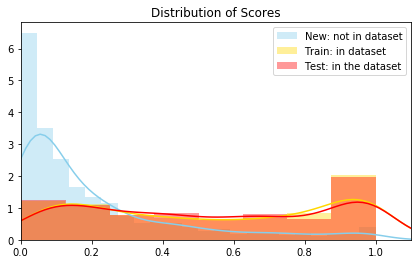

 21%|██        | 100001/473047 [4:02:02<4409:18:42, 42.55s/it]

New score:  0.20751877
Train score:  0.5286443
Test score:  0.53210557


 42%|████▏     | 199999/473047 [8:00:12<7:31:44, 10.07it/s]   

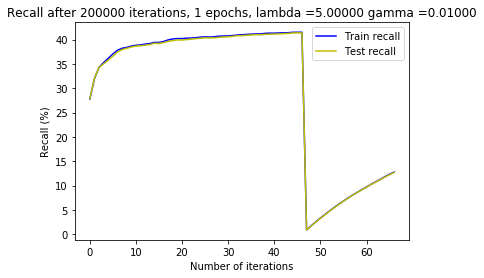

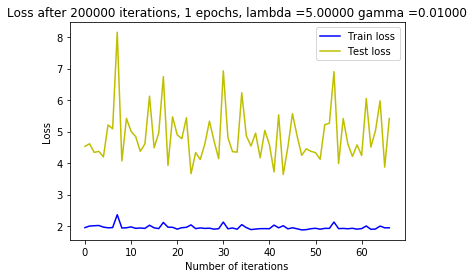

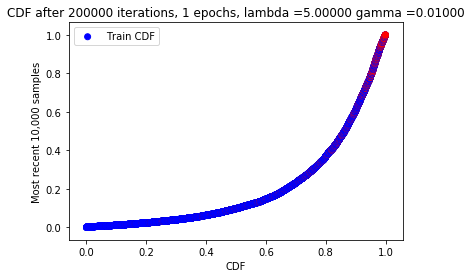

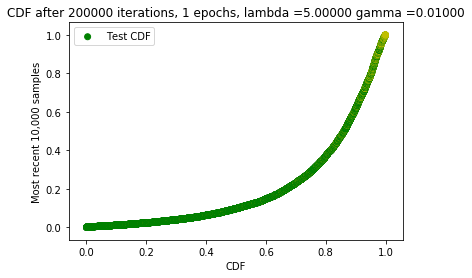

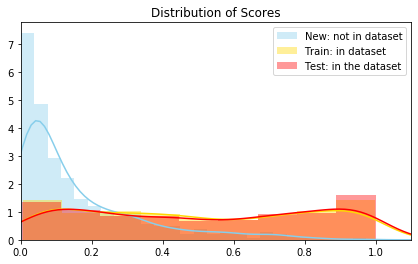

 42%|████▏     | 200001/473047 [8:02:16<1593:59:56, 21.02s/it]

New score:  0.16356097
Train score:  0.48931608
Test score:  0.48378646


 82%|████████▏ | 388352/473047 [15:33:15<3:49:59,  6.14it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 83%|████████▎ | 394381/473047 [15:49:46<2:51:45,  7.63it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 85%|████████▍ | 400000/473047 [16:01:35<2:01:06, 10.05it/s]

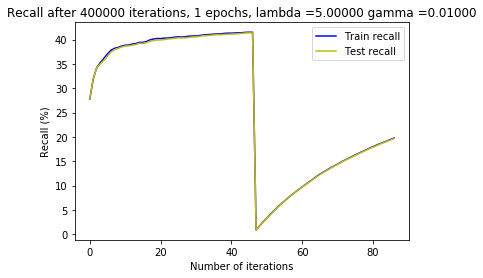

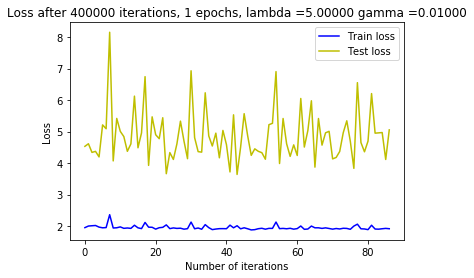

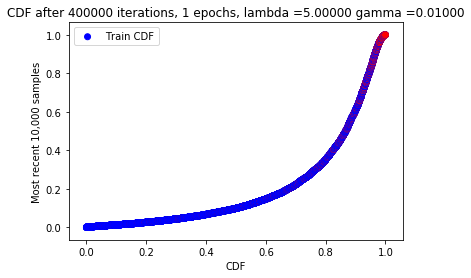

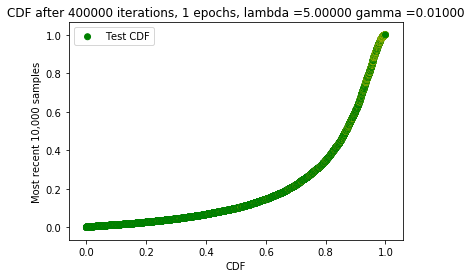

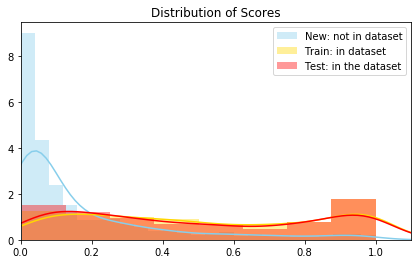

 85%|████████▍ | 400001/473047 [16:03:38<851:40:15, 41.97s/it]

New score:  0.17449956
Train score:  0.53855205
Test score:  0.49892986


 85%|████████▍ | 401199/473047 [16:06:07<2:36:53,  7.63it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 86%|████████▋ | 408508/473047 [16:20:52<2:33:15,  7.02it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 88%|████████▊ | 414600/473047 [16:36:32<2:45:48,  5.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config 

Saving to:  model_checkpoints/MinimizedVCNet/04242020.pth
Training Epoch:  2


 21%|██        | 100000/473047 [4:50:37<13:41:14,  7.57it/s] 

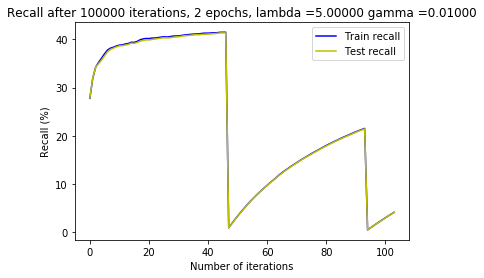

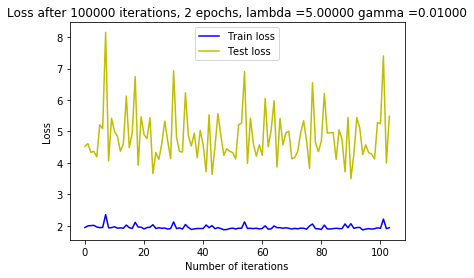

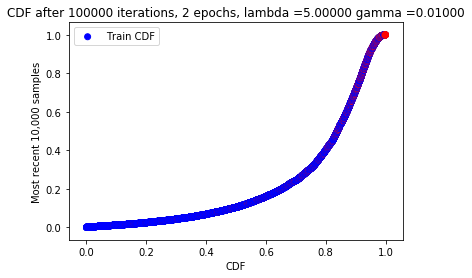

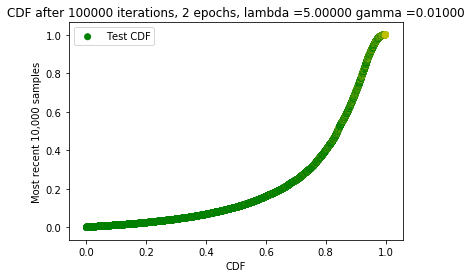

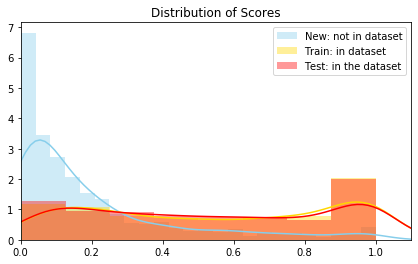

 21%|██        | 100001/473047 [4:53:00<4460:40:42, 43.05s/it]

New score:  0.20382476
Train score:  0.5242262
Test score:  0.52920985


 42%|████▏     | 199999/473047 [8:14:22<5:53:33, 12.87it/s]   

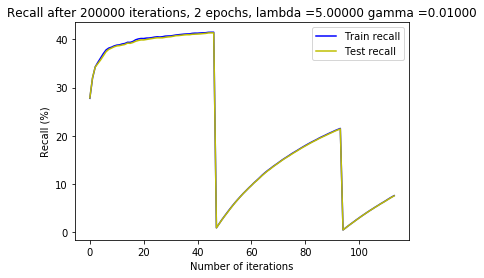

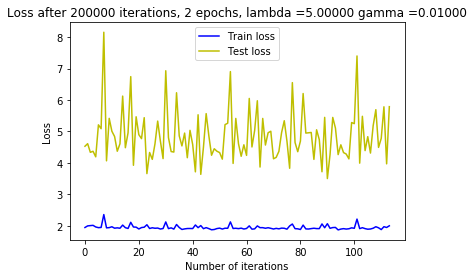

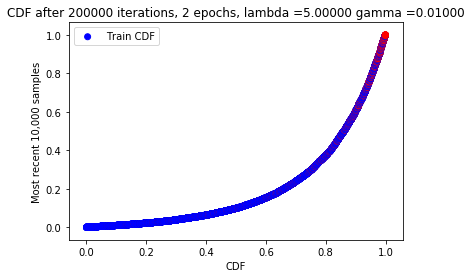

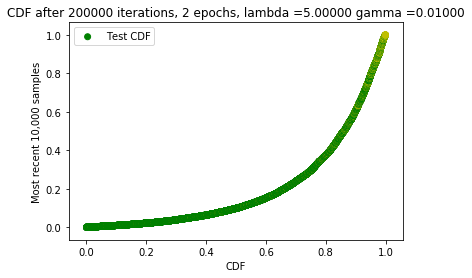

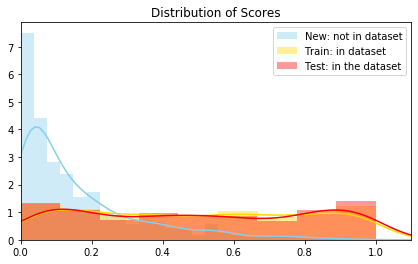

 42%|████▏     | 200003/473047 [8:15:48<812:58:23, 10.72s/it] 

New score:  0.16804446
Train score:  0.4869093
Test score:  0.48533148


 63%|██████▎   | 300000/473047 [11:20:32<5:20:02,  9.01it/s]   

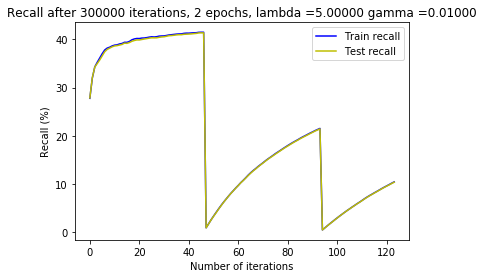

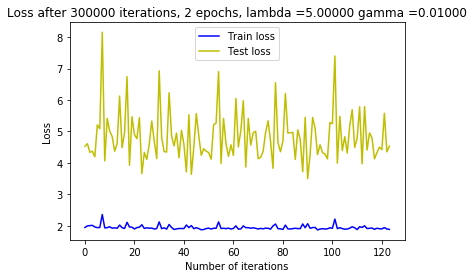

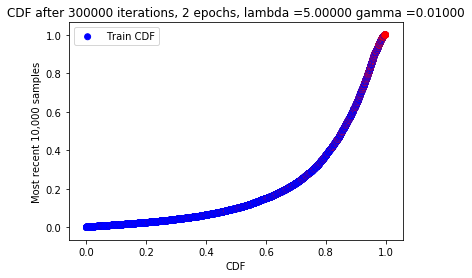

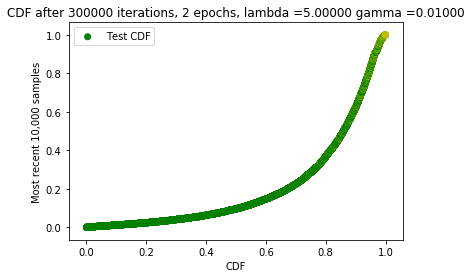

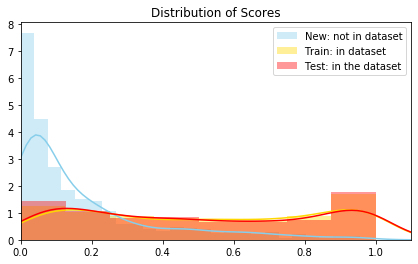

 63%|██████▎   | 300003/473047 [11:22:40<1294:57:16, 26.94s/it]

New score:  0.20113054
Train score:  0.49563992
Test score:  0.46751258


 85%|████████▍ | 400000/473047 [14:14:56<2:32:52,  7.96it/s]   

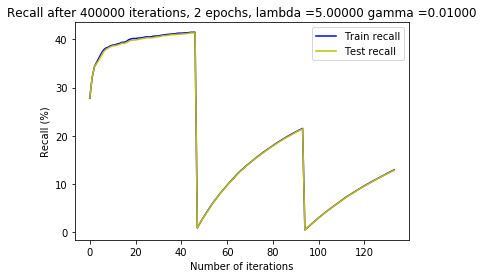

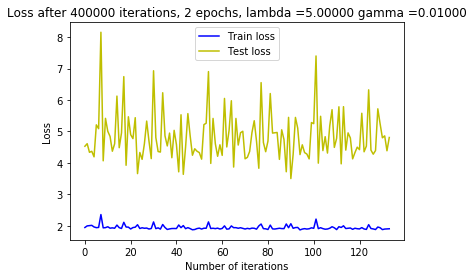

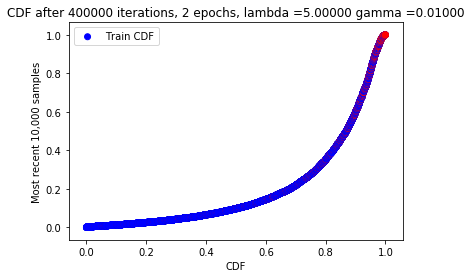

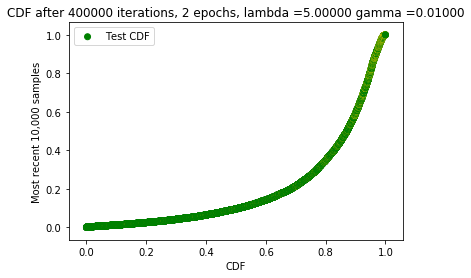

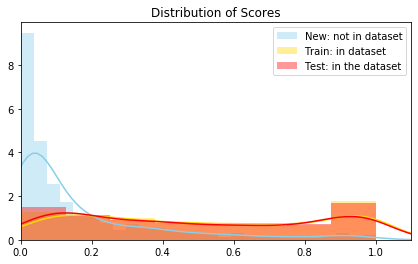

 85%|████████▍ | 400002/473047 [14:16:49<483:48:36, 23.84s/it]

New score:  0.17421143
Train score:  0.5422384
Test score:  0.50203


100%|██████████| 473047/473047 [16:23:16<00:00,  8.02it/s]    


Saving to:  model_checkpoints/MinimizedVCNet/04242020.pth
Training Epoch:  3


 21%|██        | 100000/473047 [2:51:40<9:42:36, 10.67it/s]  

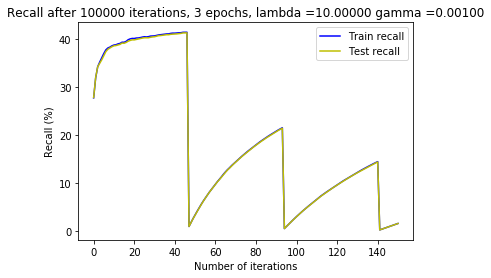

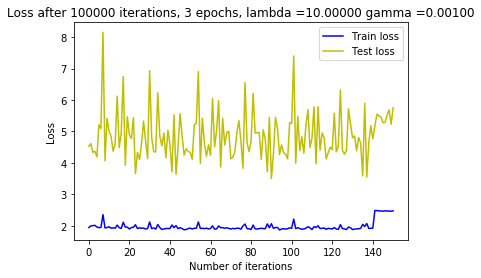

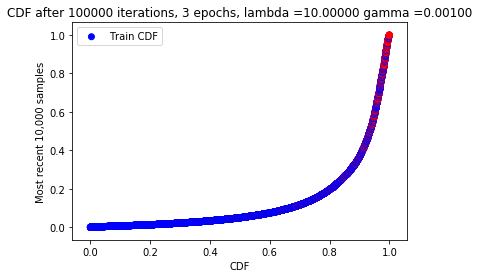

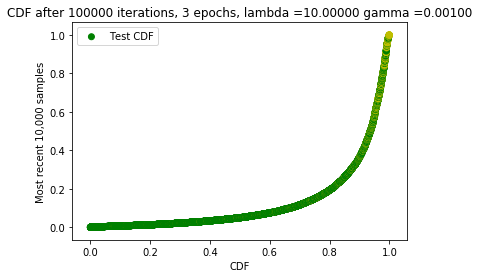

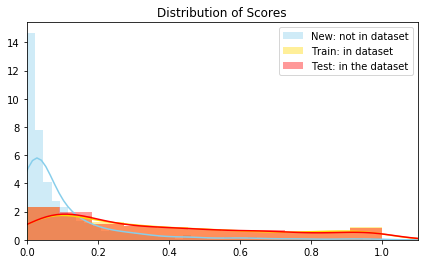

 21%|██        | 100002/473047 [2:53:12<2275:08:35, 21.96s/it]

New score:  0.11083803
Train score:  0.37481
Test score:  0.37100908


 42%|████▏     | 200000/473047 [5:44:31<6:51:48, 11.05it/s]   

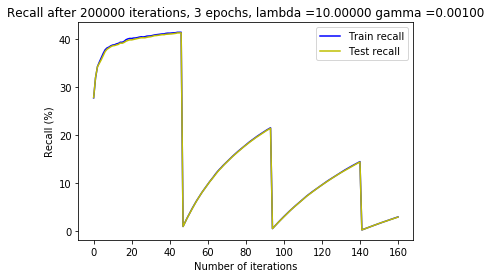

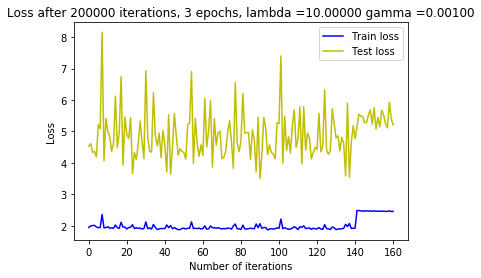

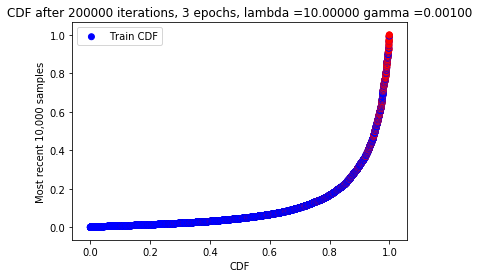

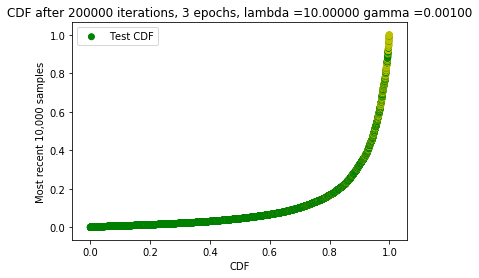

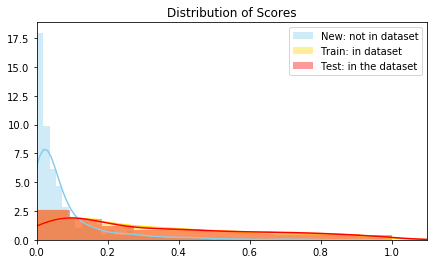

 42%|████▏     | 200002/473047 [5:46:01<1725:54:57, 22.76s/it]

New score:  0.07670807
Train score:  0.32609466
Test score:  0.32780913


 63%|██████▎   | 300000/473047 [8:36:31<4:30:17, 10.67it/s]   

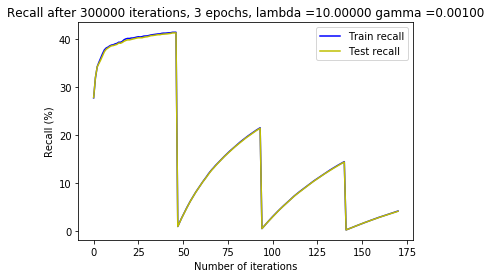

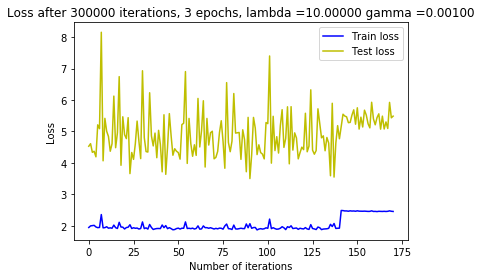

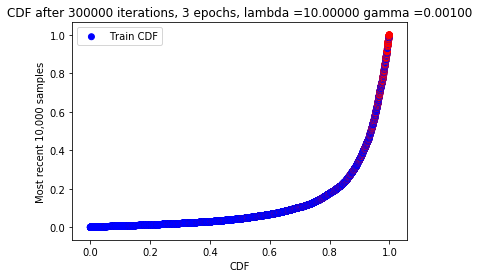

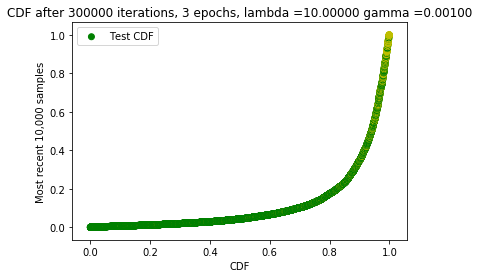

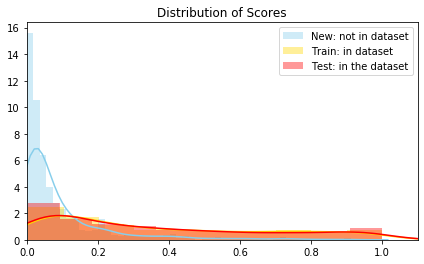

 63%|██████▎   | 300002/473047 [8:38:08<1081:10:22, 22.49s/it]

New score:  0.09480033
Train score:  0.36562866
Test score:  0.35414517


 85%|████████▍ | 400000/473047 [11:29:45<2:05:36,  9.69it/s]   

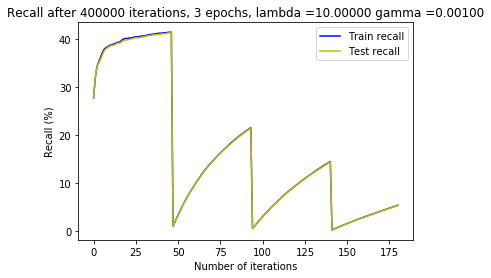

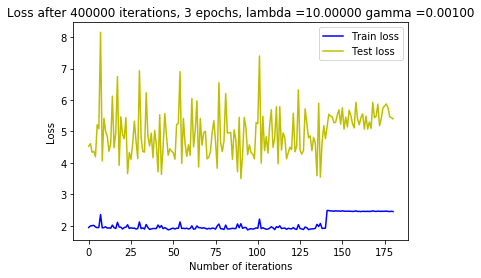

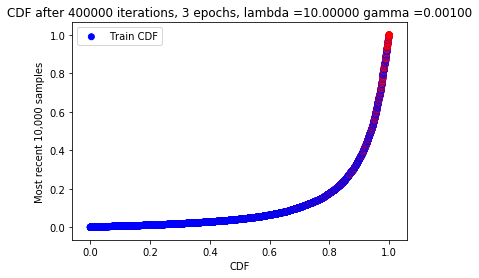

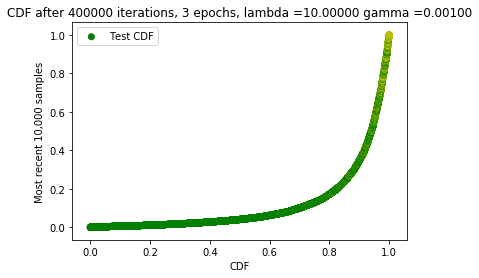

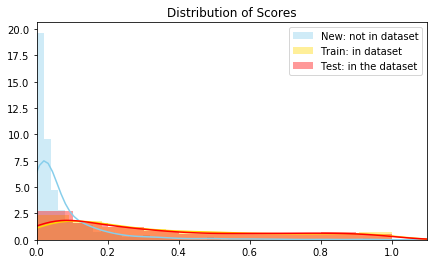

 85%|████████▍ | 400002/473047 [11:31:29<445:48:13, 21.97s/it]

New score:  0.07865001
Train score:  0.3689715
Test score:  0.3448249


100%|██████████| 473047/473047 [13:37:54<00:00,  9.64it/s]    


Saving to:  model_checkpoints/MinimizedVCNet/04242020.pth
Training Epoch:  4


 21%|██        | 100000/473047 [2:52:30<8:25:19, 12.30it/s]  

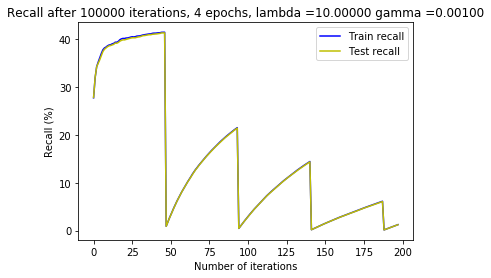

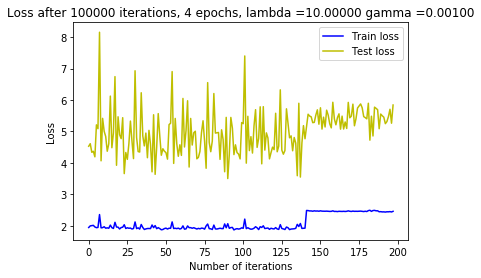

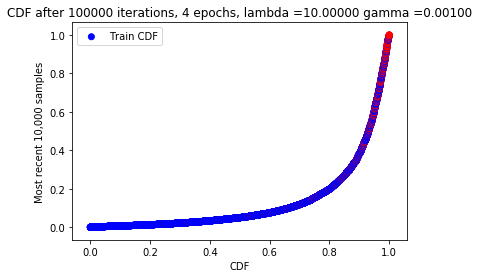

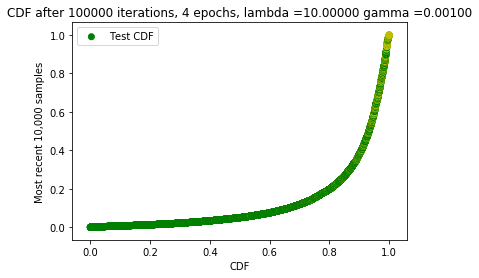

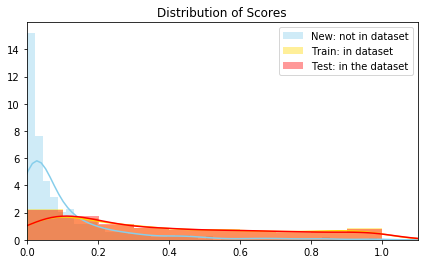

 21%|██        | 100003/473047 [2:54:06<2379:27:12, 22.96s/it]

New score:  0.11026202
Train score:  0.38385174
Test score:  0.38304764


 42%|████▏     | 199999/473047 [5:47:01<6:46:32, 11.19it/s]   

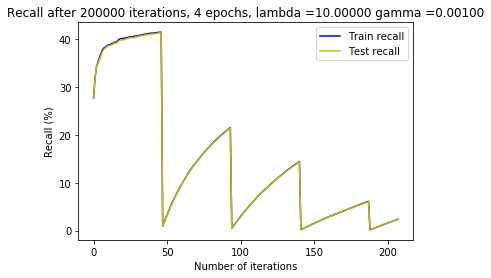

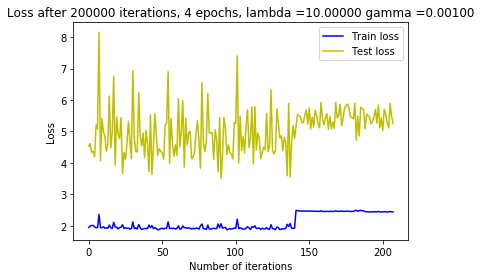

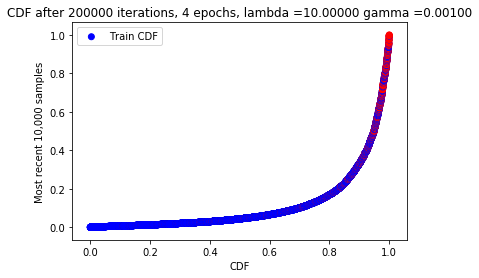

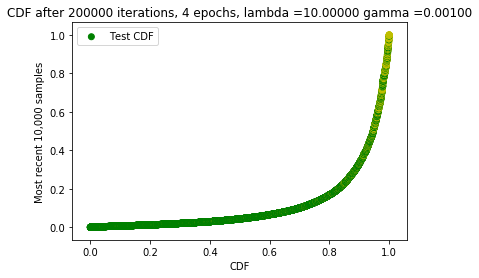

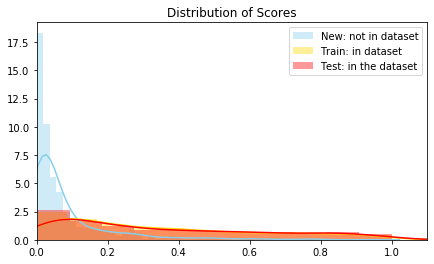

 42%|████▏     | 200002/473047 [5:48:32<854:01:32, 11.26s/it] 

New score:  0.08086428
Train score:  0.34022042
Test score:  0.33772212


 63%|██████▎   | 300000/473047 [8:42:52<3:38:16, 13.21it/s]   

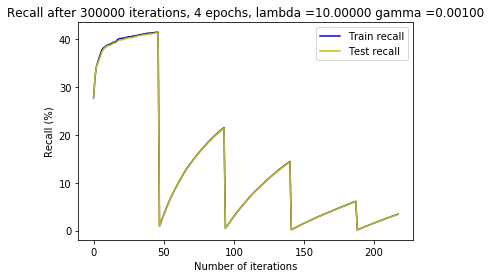

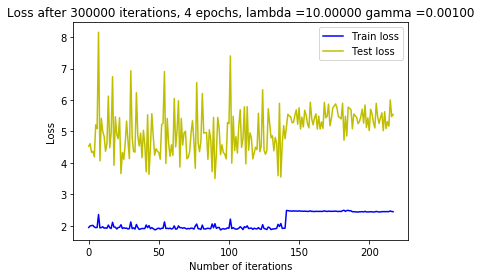

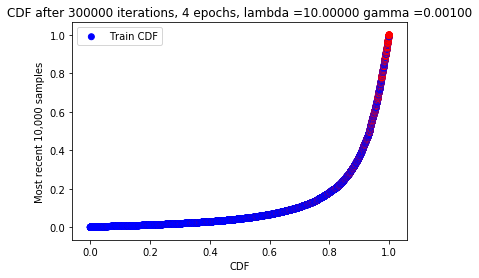

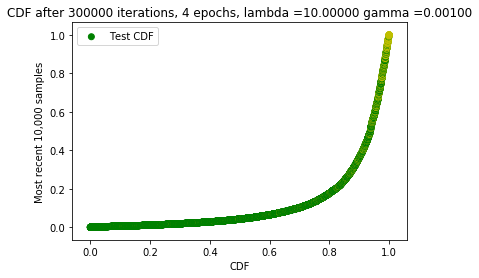

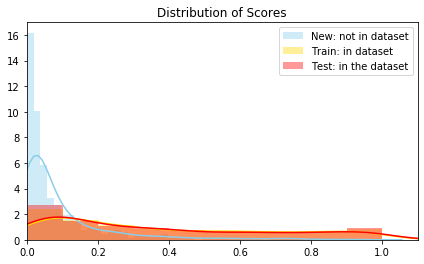

 63%|██████▎   | 300002/473047 [8:44:17<1051:51:17, 21.88s/it]

New score:  0.09666092
Train score:  0.37862659
Test score:  0.36677673


 85%|████████▍ | 400000/473047 [11:34:52<1:39:30, 12.23it/s]   

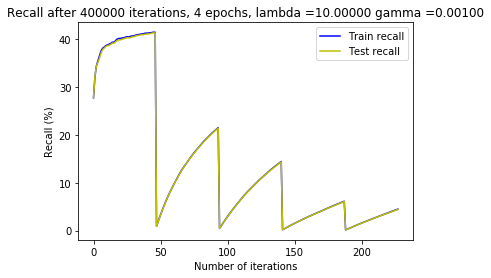

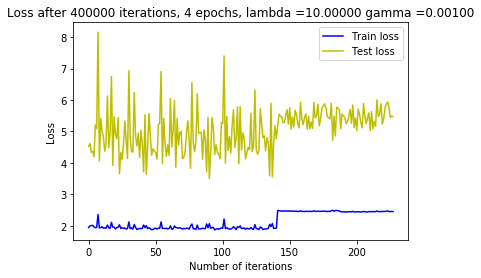

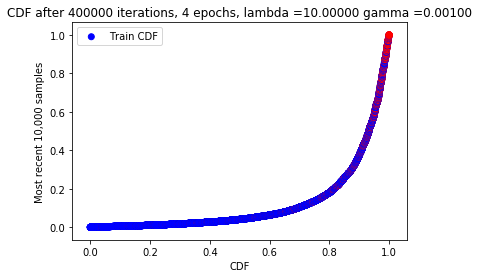

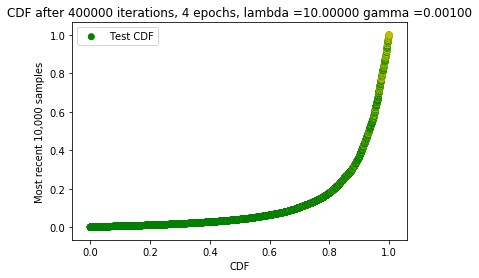

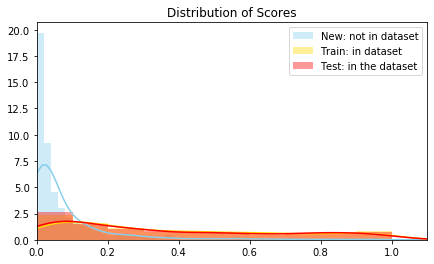

 85%|████████▍ | 400003/473047 [11:36:20<451:12:32, 22.24s/it]

New score:  0.080576815
Train score:  0.3894419
Test score:  0.3616609


100%|██████████| 473047/473047 [13:40:58<00:00,  9.60it/s]    


Saving to:  model_checkpoints/MinimizedVCNet/04242020.pth


In [23]:
model = MinimizedVCNet()
checkpoint = None
save_path = 'model_checkpoints/MinimizedVCNet/04242020.pth'
sgd(epochs=EPOCHS, lamb=lamb, gamma=gamma, run_from_checkpoint=checkpoint, save_checkpoints=save_path)